<a href="https://colab.research.google.com/github/Diego-1099/Colabfiles/blob/main/Tarea_An%C3%A1lisis_de_temas_clustering_(parte_1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Instalar librerías necesarias
!pip install gensim
!pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 29.2 MB/s eta 0:00:00




---



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Entrenando modelos y evaluando métricas... por favor espera.

--- TOP 5 MEJORES CONFIGURACIONES ---


,num_topics,alpha,beta,Perplejidad,Coherencia
23,5,asymmetric,0.1,-6.330663,0.569174
2,3,symmetric,0.1,-6.252256,0.500127
14,4,asymmetric,0.1,-6.345433,0.481533
21,5,asymmetric,symmetric,-6.001075,0.469378
22,5,asymmetric,auto,-5.974537,0.469378


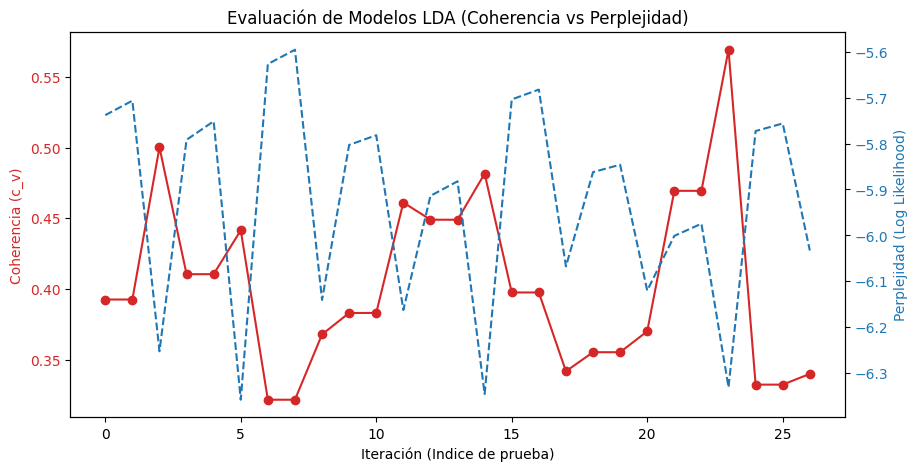

In [6]:
# ==============================================================================
# LIBRERIAS
# ==============================================================================

import pandas as pd
import matplotlib.pyplot as plt
import gensim
import gensim.corpora as corpora
from gensim.models import LdaModel, CoherenceModel
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import warnings

# Configuración inicial y descargas de NLTK
warnings.filterwarnings("ignore", category = DeprecationWarning)
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

# ==============================================================================
# 1. DEFINICIÓN DE DATOS Y PREPROCESAMIENTO
# ==============================================================================

documents = [
    # Política
    "El presidente anunció nuevas reformas durante la conferencia en el congreso.",
    "Los partidos políticos debatieron sobre el futuro del sistema electoral.",
    "La oposición critica la gestión gubernamental en materia de seguridad.",
    "Miles de personas protestaron en la capital contra la nueva ley propuesta.",
    "Se firmó un acuerdo internacional para fomentar la cooperación política.",
    # Economía
    "El banco central decidió aumentar las tasas de interés para controlar la inflación.",
    "La economía del país creció un 3% durante el segundo trimestre del año.",
    "Las exportaciones de productos agrícolas aumentaron notablemente.",
    "El desempleo bajó por tercer mes consecutivo, según datos oficiales.",
    "Los inversores mostraron confianza ante las nuevas políticas económicas.",
    # Deportes
    "La selección nacional clasificó a la final del campeonato continental.",
    "El delantero estrella fue transferido al club europeo por una suma millonaria.",
    "Los fanaticos celebraron la victoria con una caravana en las calles.",
    "El equipo local perdió el partido decisivo por un gol en el último minuto.",
    "La liga anunció cambios en el reglamento para la próxima temporada.",
    # Tecnología
    "La empresa lanzó un nuevo smartphone con inteligencia artificial integrada.",
    "Se descubrió una vulnerabilidad crítica en el sistema operativa.",
    "La inversión en energías renovables incluye avances en baterías inteligentes.",
    "El uso de la automatización ha transformado la industria manufacturera.",
    "Expertos debaten sobre los riesgos éticos del desarrollo de la IA.",
    # Medio ambiente
    "El cambio climático está afectando los patrones de lluvia en la región.",
    "Un nuevo informe advierte sobre la pérdida acelerada de biodiversidad.",
    "Se implementaron miles de políticas públicas para reducir las emisiones de carbono.",
    "Miles de voluntarios participaron en una jornada de reforestación.",
    "Organizaciones internacionales exigen medidas urgentes contra la contaminación."
]

# Preprocesamiento
stop_words = set(stopwords.words('spanish'))
texts = [
    [word for word in word_tokenize(doc.lower()) if word.isalpha() and word not in stop_words]
    for doc in documents
]

# Crear Diccionario y Corpus
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]

# ==============================================================================
# 2. EXPERIMENTO: BUCLE DE PARÁMETROS (Grid Search)
# ==============================================================================

# Parámetros a probar
num_topics_list = [3, 4, 5]
alpha_list = ["symmetric", "asymmetric", 0.1]
beta_list = ["symmetric", "auto", 0.1]

resultados = []

print("Entrenando modelos y evaluando métricas... por favor espera.")

for num_topics in num_topics_list:
    for alpha in alpha_list:
        for beta in beta_list:
            try:
                # Crear modelo con la combinación actual
                lda_model = LdaModel(
                    corpus = corpus,
                    id2word = id2word,
                    num_topics = num_topics,
                    random_state = 42,
                    alpha = alpha,
                    eta = beta,
                    passes = 15
                )

                # Calcular Métricas
                # 1. Perplejidad (Menor es mejor algebraicamente, pero en gensim es log-likelihood)
                perplexity = lda_model.log_perplexity(corpus)

                # 2. Coherencia (Mayor es mejor, cerca de 1)
                coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
                coherence = coherence_model.get_coherence()

                resultados.append({
                    'num_topics': num_topics,
                    'alpha': str(alpha),
                    'beta': str(beta),
                    'Perplejidad': perplexity,
                    'Coherencia': coherence
                })
            except Exception as e:
                print(f"Error en combinación {num_topics}-{alpha}-{beta}: {e}")

# ==============================================================================
# 3. RESULTADOS
# ==============================================================================

df_resultados = pd.DataFrame(resultados)

# Ordenar por mejor coherencia
df_sorted = df_resultados.sort_values(by = "Coherencia", ascending = False)

print("\n--- TOP 5 MEJORES CONFIGURACIONES ---")
display(df_sorted.head(5))

# Gráfica de Coherencia vs Perplejidad
fig, ax1 = plt.subplots(figsize = (10, 5))

color = 'tab:red'
ax1.set_xlabel('Iteración (Indice de prueba)')
ax1.set_ylabel('Coherencia (c_v)', color=color)
ax1.plot(df_resultados.index, df_resultados["Coherencia"], color=color, marker = 'o', label = "Coherencia")
ax1.tick_params(axis = 'y', labelcolor = color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Perplejidad (Log Likelihood)', color = color)
ax2.plot(df_resultados.index, df_resultados["Perplejidad"], color = color, linestyle = '--', label = "Perplejidad")
ax2.tick_params(axis = 'y', labelcolor = color)

plt.title("Evaluación de Modelos LDA (Coherencia vs Perplejidad)")
plt.show()

In [7]:
# ==============================================================================
# 4. VISUALIZACIÓN FINAL (pyLDAvis) DEL MEJOR MODELO
# ==============================================================================

# Obtener los parámetros del mejor modelo
mejor_config = df_sorted.iloc[0]
print(f"Generando visualización para el mejor modelo:")
print(f"Topics: {mejor_config['num_topics']}, Alpha: {mejor_config['alpha']}, Beta: {mejor_config['beta']}")

# Reconvertir parámetros string a float si es necesario
alpha_val = float(mejor_config['alpha']) if mejor_config['alpha'].replace('.','',1).isdigit() else mejor_config['alpha']
beta_val = float(mejor_config['beta']) if mejor_config['beta'].replace('.','',1).isdigit() else mejor_config['beta']

# Re-entrenar el modelo ganador
final_lda_model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=int(mejor_config['num_topics']),
    random_state=42,
    alpha=alpha_val,
    eta=beta_val,
    passes=20
)

# Visualizar
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(final_lda_model, corpus, id2word)
vis

Generando visualización para el mejor modelo:
Topics: 5, Alpha: asymmetric, Beta: 0.1


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.172591  0.078657       1        1  44.793648
1      0.196414  0.050705       2        1  34.730230
2     -0.022110 -0.164967       3        1  12.314881
4     -0.002663  0.018000       4        1   6.202795
3      0.000950  0.017605       5        1   1.958446, topic_info=             Term      Freq     Total Category  logprob  loglift
20          miles  2.000000  2.000000  Default  30.0000  30.0000
56          según  0.000000  0.000000  Default  29.0000  29.0000
52          datos  0.000000  0.000000  Default  28.0000  28.0000
50           bajó  0.000000  0.000000  Default  27.0000  27.0000
51    consecutivo  0.000000  0.000000  Default  26.0000  26.0000
..            ...       ...       ...      ...      ...      ...
10      políticos  0.020505  1.070787   Topic5  -5.0039  -0.0225
14  gubernamental  0.020505  1.070786   Topic5  -5.0039  -0.0225
26    cooperación  0.020505  1.070786   Topic5  -5.0039  -0.0225
48   notablemente  0.020505  1.070786   Topic5  -5.0039  -0.0225
91        próxima  0.020505  1.070786   Topic5  -5.0039  -0.0225

[246 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
129       1  0.933893       acelerada
25        1  0.933893         acuerdo
0         1  0.548027         anunció
0         2  0.548027         anunció
31        2  0.971096        aumentar
...     ...       ...             ...
116       1  0.933893             uso
80        2  0.971097        victoria
142       3  1.162881     voluntarios
104       2  0.971097  vulnerabilidad
122       2  0.971097          éticos

[115 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 5, 4])